#IMPORT DATA

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/CV"



In [4]:
!pip install opencv-python


In [5]:
!pip install opencv-contrib-python


#Thay đổi kích thước và chuẩn hóa ảnh

RESIZE 64x64 vì đây là kích thước phù hợp cho bộ dữ liệu toàn ảnh nhỏ
- Không chọn quá lớn (ảnh nhỏ sẽ bị phóng to mờ).
- Không chọn quá nhỏ (ảnh lớn sẽ mất chi tiết).


In [6]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 50

In [ ]:
def load_and_preprocess_img(path, label, base_dir):
    full_path = tf.strings.join([base_dir, "/", path])
    img = tf.io.read_file(full_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label_id = table.lookup(label)
    label_onehot = tf.one_hot(label_id, num_classes)
    return img, label_onehot


In [7]:
train_df  = pd.read_csv(os.path.join(data_dir, "Train.csv"))
test_df  = pd.read_csv(os.path.join(data_dir, "Test.csv"))

train_imgs = os.path.join(data_dir, "Train")
test_imgs =  os.path.join(data_dir, "Test")

In [ ]:
train_df  = pd.read_csv(os.path.join(data_dir, "Train.csv"))
test_df  = pd.read_csv(os.path.join(data_dir, "Test.csv"))

train_imgs = os.path.join(data_dir, "Train_processed")
test_imgs =  os.path.join(data_dir, "Test")

#hsv để tăng cường độ sáng

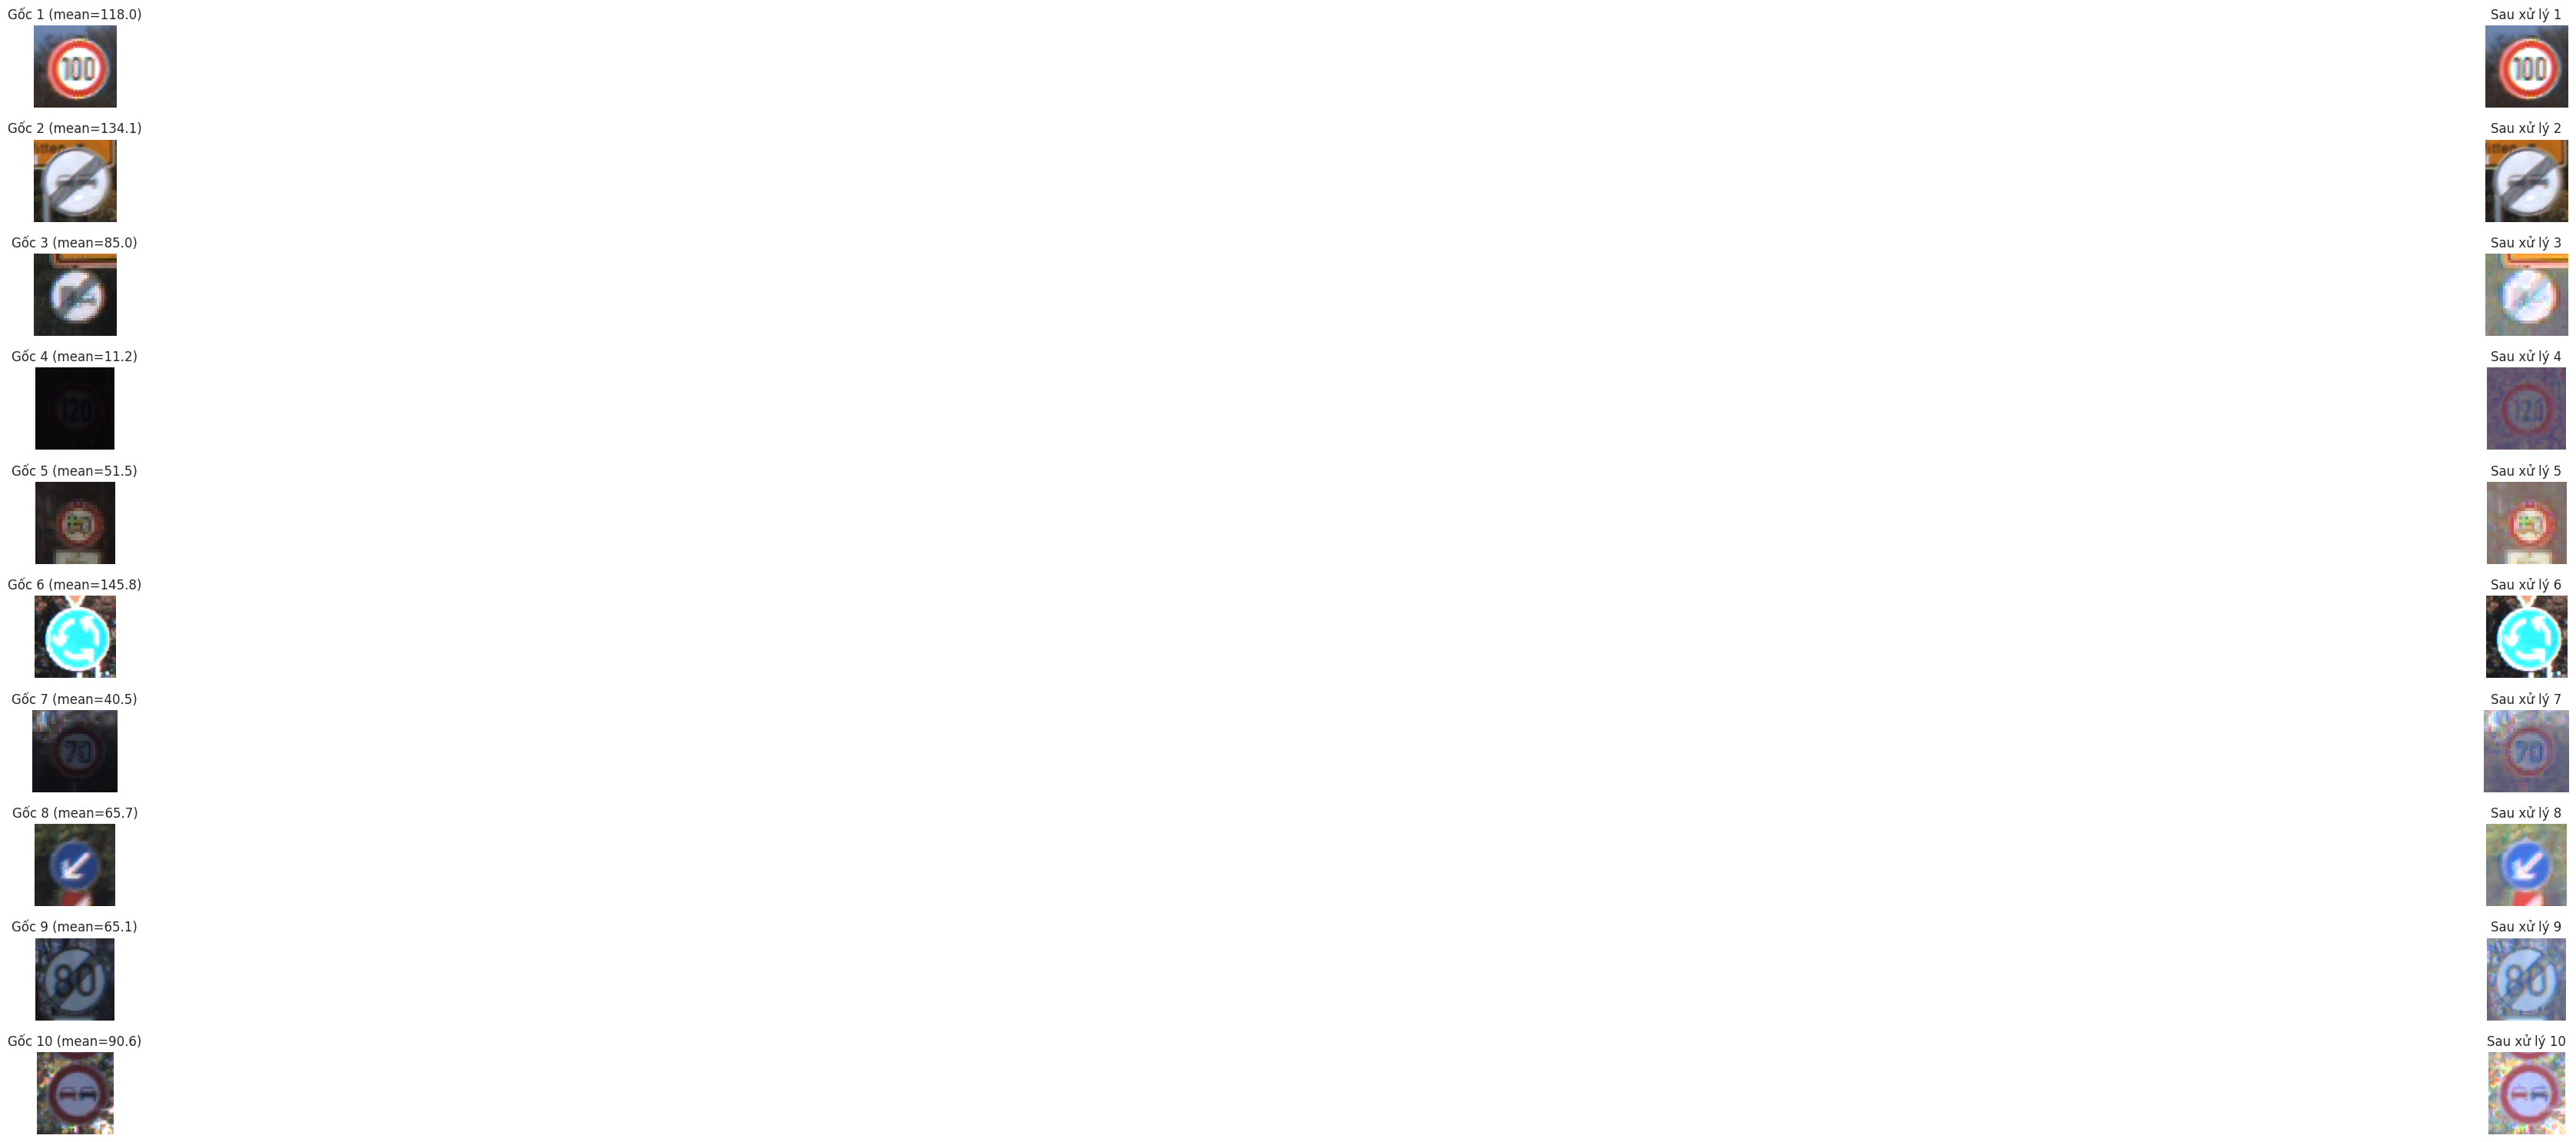

In [10]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

train_dir = r"/content/drive/MyDrive/CV/Train"

# Lấy một số ảnh để minh họa
sample_files = []
for class_id in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_id)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path)[:1]:
            sample_files.append(os.path.join(class_path, file))

plt.figure(figsize=(64, 64))

for i, file in enumerate(sample_files[:10]):
    img_bgr = cv2.imread(file)
    if img_bgr is None:
        continue

    # Tính độ sáng trung bình
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)

    # Nếu ảnh quá tối (<80), tăng sáng
    if mean_brightness < 100:
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = cv2.add(v, 100)  # tăng sáng thêm 50
        v = np.clip(v, 0, 255)
        hsv = cv2.merge((h, s, v))
        bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        bright_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # giữ nguyên

    # Hiển thị ảnh gốc
    plt.subplot(len(sample_files), 2, 2*i+1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Gốc {i+1} (mean={mean_brightness:.1f})")
    plt.axis("off")

    # Hiển thị ảnh sau xử lý
    plt.subplot(len(sample_files), 2, 2*i+2)
    plt.imshow(bright_img)
    plt.title(f"Sau xử lý {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#Làm nét

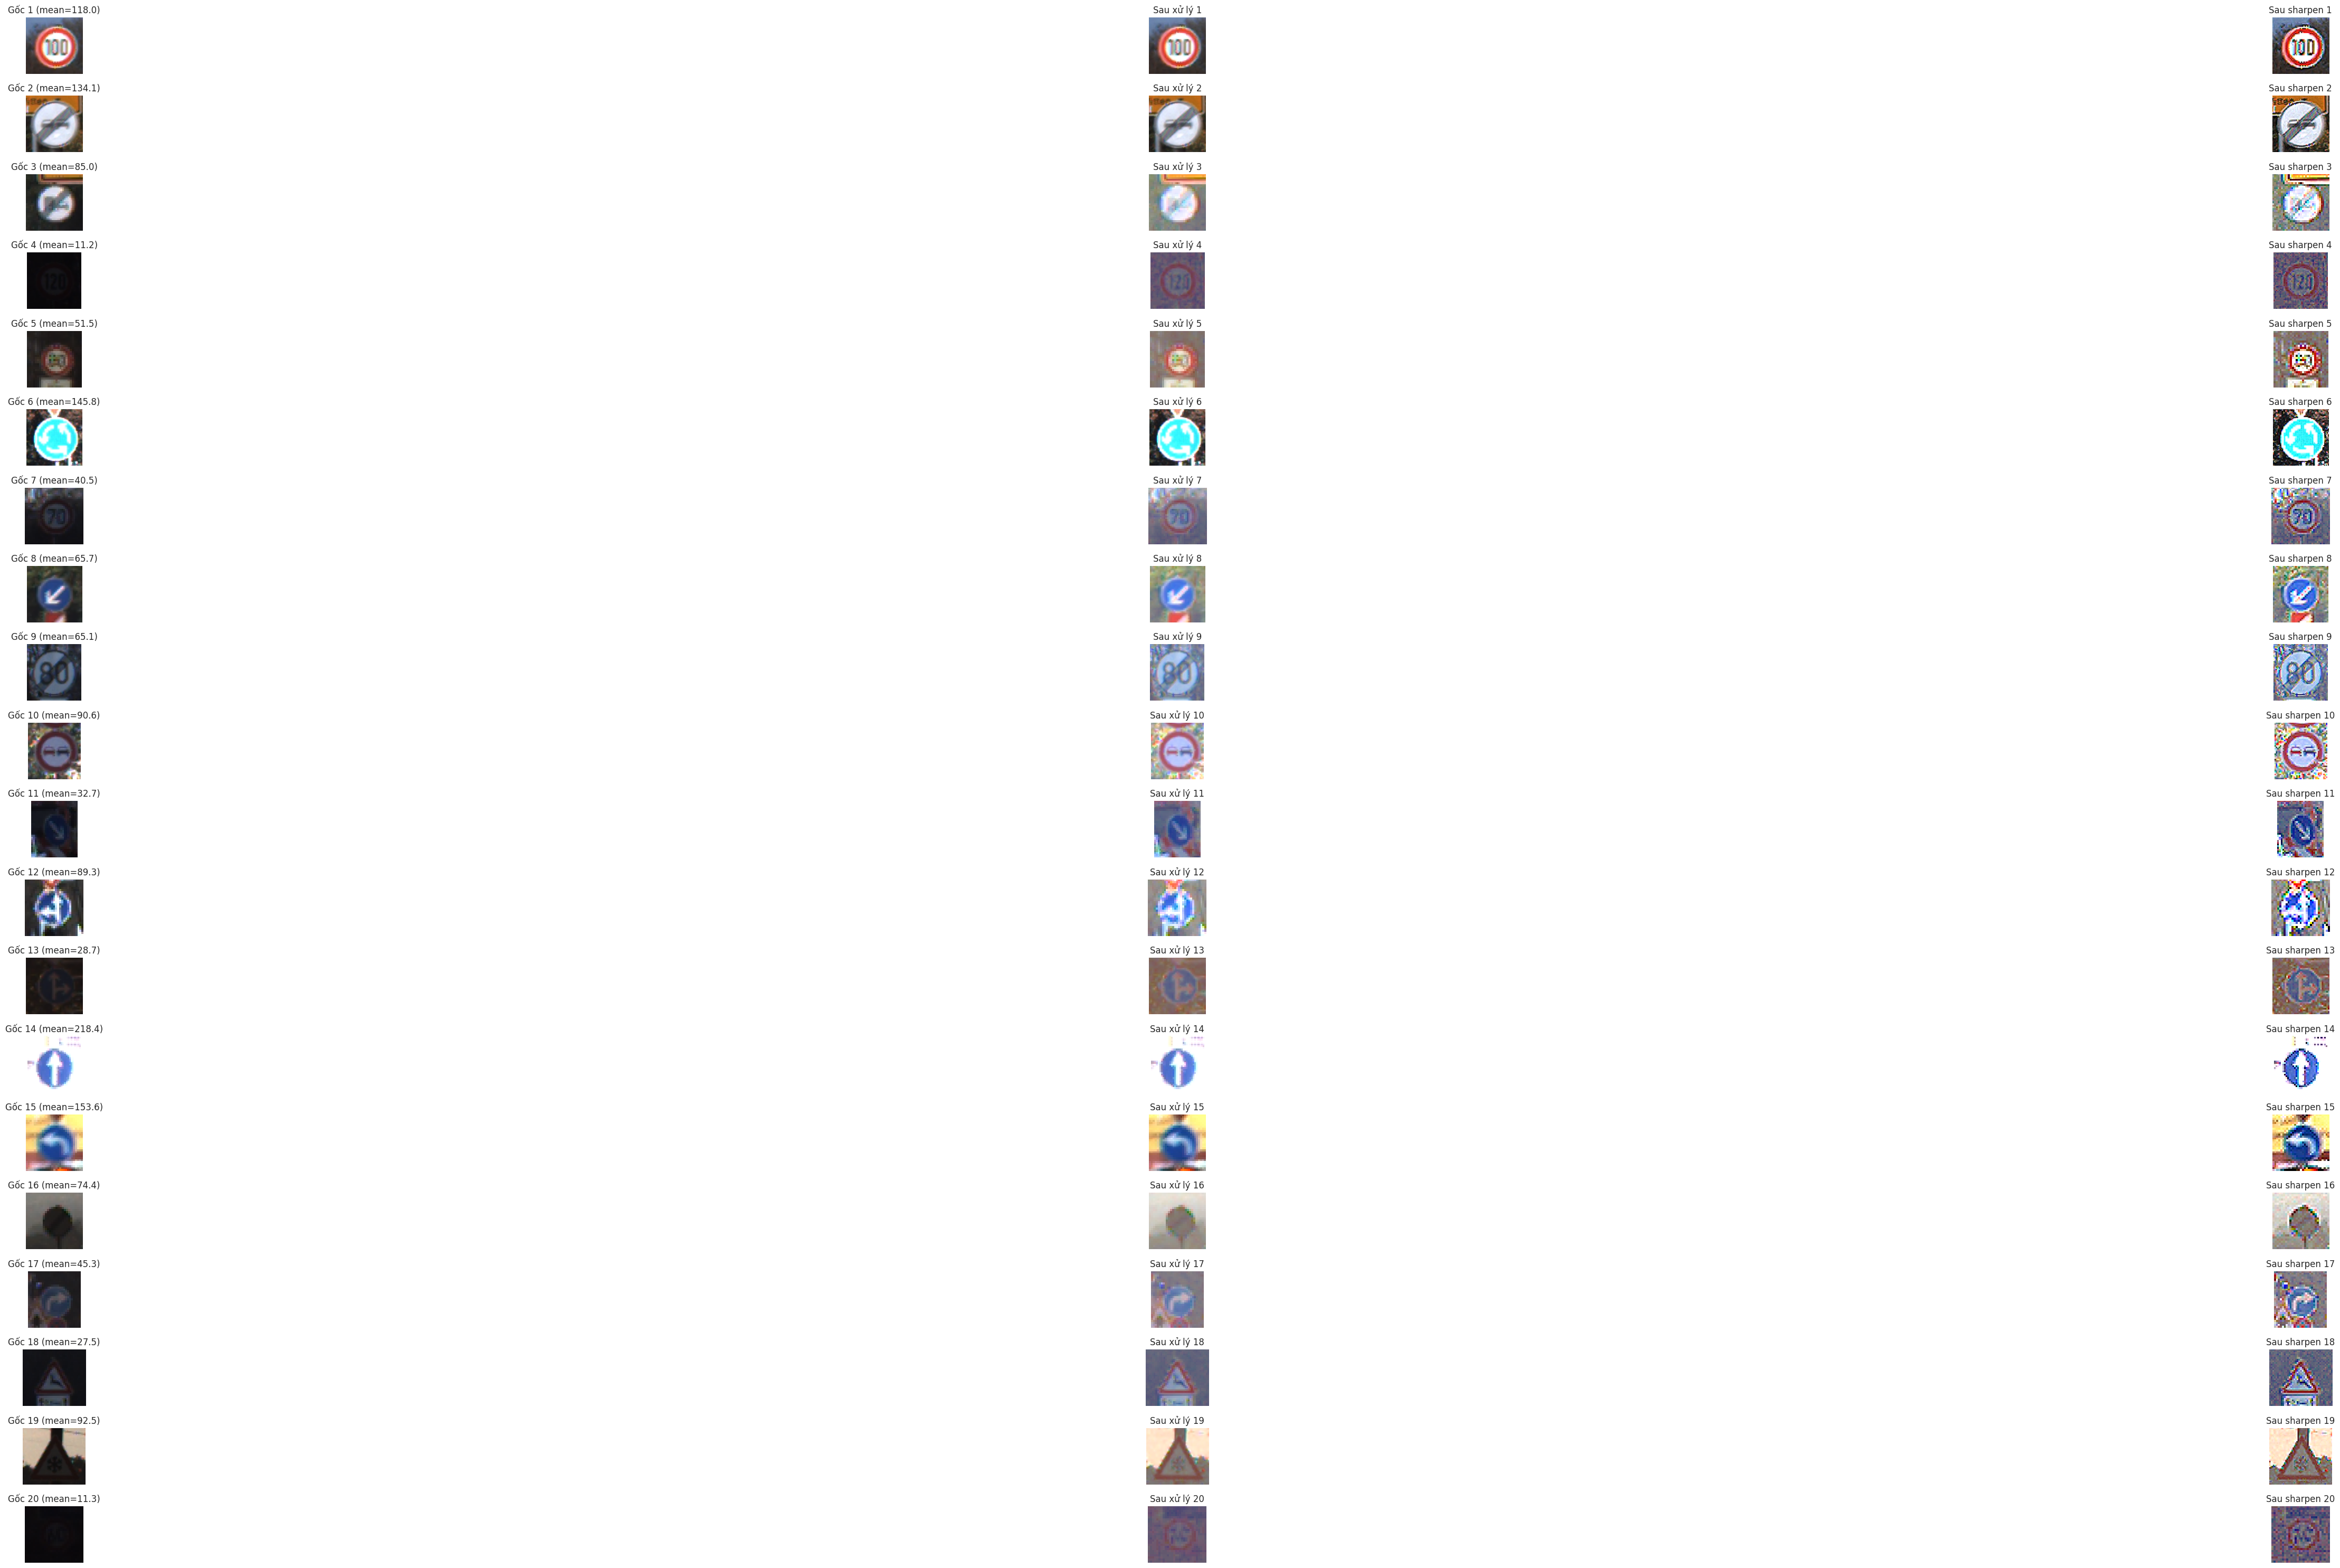

In [18]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

train_dir = r"/content/drive/MyDrive/CV/Train"

# Lấy một số ảnh để minh họa
sample_files = []
for class_id in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_id)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path)[:1]:
            sample_files.append(os.path.join(class_path, file))

plt.figure(figsize=(64, 64))

for i, file in enumerate(sample_files[:20]):
    img_bgr = cv2.imread(file)
    if img_bgr is None:
        continue

    # Tính độ sáng trung bình
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)

    # Nếu ảnh quá tối (<100), tăng sáng
    if mean_brightness < 100:
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = cv2.add(v, 100)  # tăng sáng thêm 100
        v = np.clip(v, 0, 255)
        hsv = cv2.merge((h, s, v))
        bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        bright_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # giữ nguyên

    # ⚡ Thêm bước sharpen
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(cv2.cvtColor(bright_img, cv2.COLOR_RGB2BGR), -1, sharpen_kernel)
    sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh gốc
    plt.subplot(len(sample_files), 3, 3*i+1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Gốc {i+1} (mean={mean_brightness:.1f})")
    plt.axis("off")

    # Hiển thị ảnh sau xử lý sáng
    plt.subplot(len(sample_files), 3, 3*i+2)
    plt.imshow(bright_img)
    plt.title(f"Sau xử lý {i+1}")
    plt.axis("off")

    # Hiển thị ảnh sau sharpen
    plt.subplot(len(sample_files), 3, 3*i+3)
    plt.imshow(sharpened)
    plt.title(f"Sau sharpen {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import os
import numpy as np

train_dir = r"/content/drive/MyDrive/CV/Train"
out_dir = r"/content/drive/MyDrive/CV/Train_processed"

os.makedirs(out_dir, exist_ok=True)

for class_id in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_id)
    if os.path.isdir(class_path):
        out_class_path = os.path.join(out_dir, class_id)
        os.makedirs(out_class_path, exist_ok=True)

        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                continue

            # Tính độ sáng trung bình
            gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            mean_brightness = np.mean(gray)

            # Nếu ảnh quá tối (<100), tăng sáng
            if mean_brightness < 100:
                hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
                h, s, v = cv2.split(hsv)
                v = cv2.add(v, 100)  # tăng sáng thêm 100
                v = np.clip(v, 0, 255)
                hsv = cv2.merge((h, s, v))
                bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            else:
                bright_img = img_bgr.copy()

            # ⚡ Thêm bước sharpen
            sharpen_kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
            sharpened = cv2.filter2D(bright_img, -1, sharpen_kernel)

            # Lưu ảnh đã xử lý
            out_path = os.path.join(out_class_path, file)
            cv2.imwrite(out_path, sharpened)

print("✅ Đã xử lý và lưu toàn bộ ảnh vào:", out_dir)

✅ Đã xử lý và lưu toàn bộ ảnh vào: /content/drive/MyDrive/CV/Train_processed


#VẼ histogram xem đặc trưng sáng tối

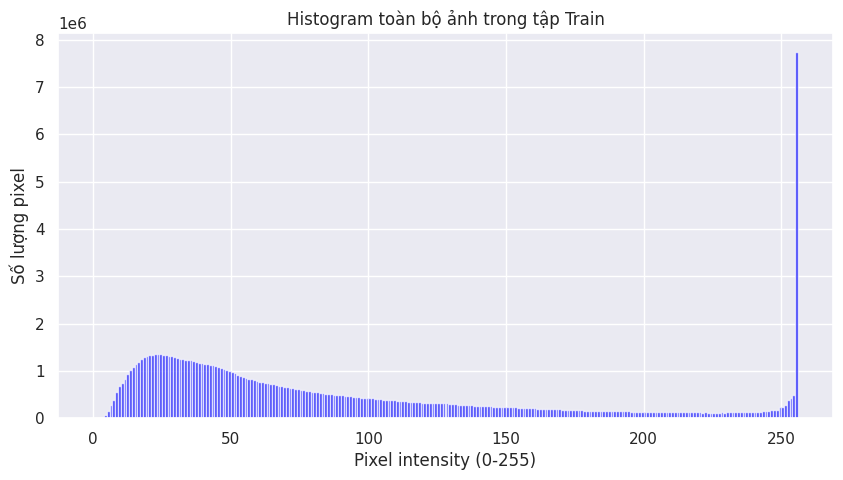

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

train_dir = r"/content/drive/MyDrive/CV/Train"

all_pixels = []

# Duyệt qua tất cả file ảnh trong thư mục train
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # đọc ảnh grayscale
            if img is not None:
                all_pixels.extend(img.ravel())  # thêm toàn bộ pixel vào list

# Chuyển sang numpy array
all_pixels = np.array(all_pixels)

# Vẽ histogram
plt.figure(figsize=(10,5))
plt.hist(all_pixels, bins=256, range=(0,256), color='blue', alpha=0.7)
plt.title("Histogram toàn bộ ảnh trong tập Train")
plt.xlabel("Pixel intensity (0-255)")
plt.ylabel("Số lượng pixel")
plt.show()

#Tổng quan ảnh

In [ ]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)",
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)",
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)",
    8: "Speed Limit (120Km/hr)", 9: "No Passing",
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way",
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [ ]:
# Đếm số lượng ảnh theo từng cặp (Width, Height)
size_counts = train_df.groupby(["Width", "Height"]).size().reset_index(name="Count")

print(size_counts[10:])

      Width  Height  Count
10       26      26     85
11       26      27    108
12       26      28     70
13       26      29     27
14       26      30      7
...     ...     ...    ...
2919    226     213      1
2920    229     205      1
2921    230     201      1
2922    231     213      1
2923    243     225      1

[2914 rows x 3 columns]


In [ ]:
mask = size_counts["Width"].between(0, 60) | size_counts["Height"].between(0, 60)

total_images = size_counts.loc[mask, "Count"].sum()

print(total_images)

31185


In [ ]:
train_df['ClassName'].value_counts()


,count
ClassName,
Speed Limit (50Km/hr),2250
Speed Limit (30Km/hr),2220
Yeild right of way,2160
Priotity Road,2100
Keep right,2070
No Passing for trucks over 3.5 tons,2010
Speed Limit (70Km/hr),1980
Speed Limit (80Km/hr),1860
Construction side ahead,1500


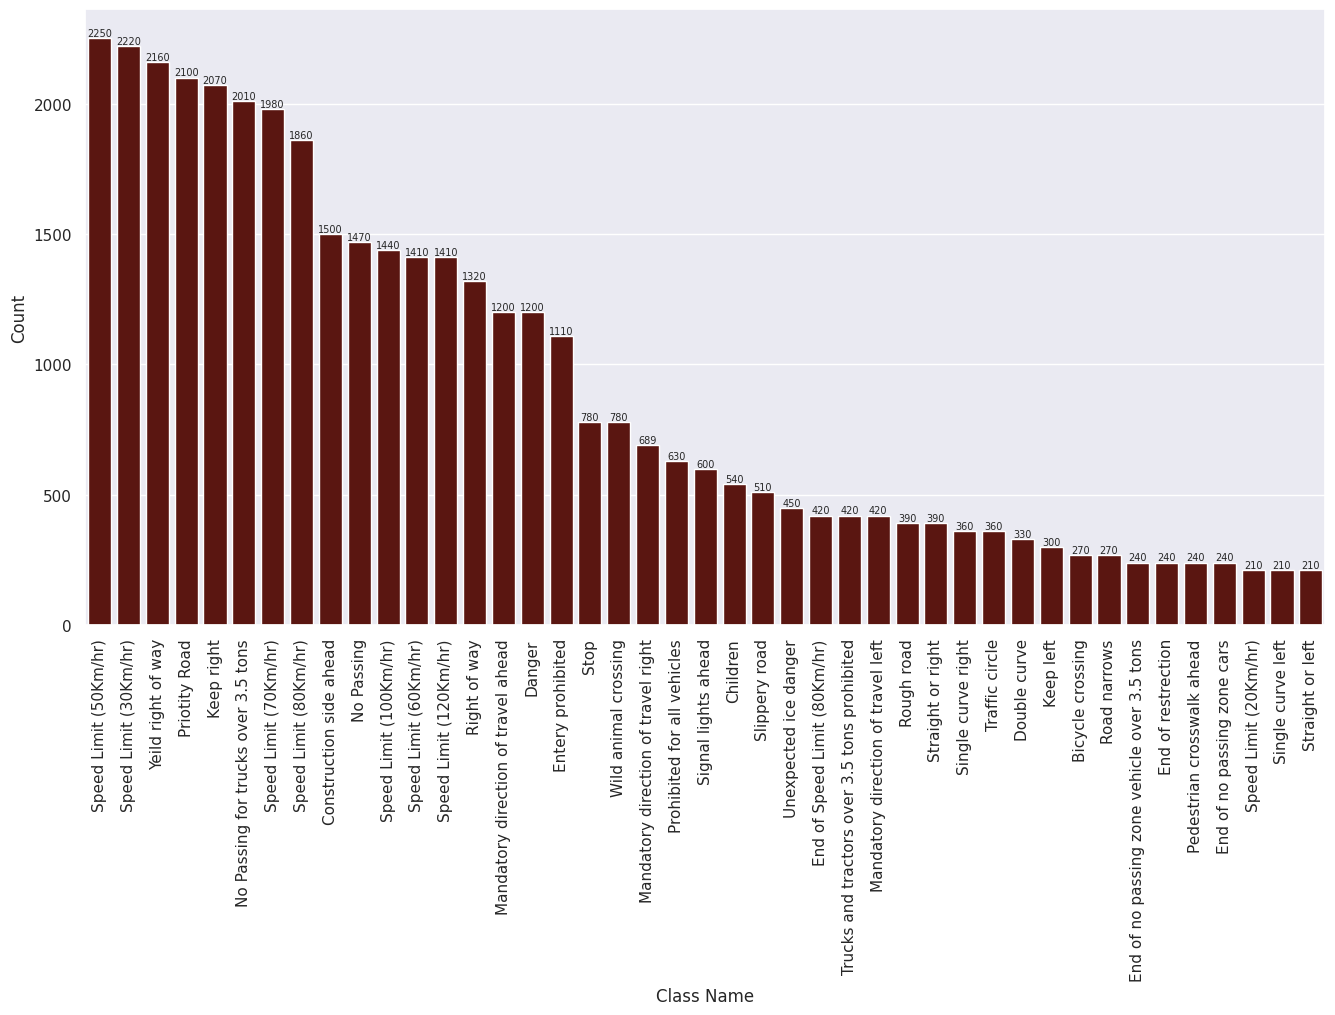

In [ ]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#660B05")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()